# Fuzzing: Breaking Things with Random Inputs

In this chapter, we'll start with one of the simplest test generation techniques.  The key idea of random text generation, also known as "fuzzing", is to feed a _string of random characters_ into a program in the hope to uncover failures.

**Prerequisites**

* You should know fundamentals of software testing; for instance, from the chapter ["Introduction to Software Testing"](Intro_Testing.ipynb).
* You should have a decent understanding of Python; for instance, from the [Python tutorial](https://docs.python.org/3/tutorial/).


## A Testing Assignment

Fuzzing was conceived by Bart Miller in 1989 as a programming exercise for his students at the University of Wisconsin-Madison.  The [assignment](http://pages.cs.wisc.edu/~bart/fuzz/CS736-Projects-f1988.pdf) read 

> The goal of this project is to evaluate the robustness of various UNIX utility programs, given an unpredictable input stream. [...] First, you will build a _fuzz generator_. This is a program that will output a random character stream. Second, you will take the fuzz generator and use it to attack as many UNIX utilities as possible, with the goal of trying to break them.

This assignment captures the essence of fuzzing: _Create random inputs, and see if they break things._  Just let it run long enough and you'll see.

## A Simple Fuzzer

Let us try to fulfill this assignment and build a fuzz generator.  The idea is to produce random characters, adding them to a buffer string variable (`out`), and finally returning the string.

This implementation uses the following Python features and functions:

* `random.randrange(start, end)` – return a random number $[$ `start`, `end` $)$
* `range(start, end)` – create a list with integers from `start` to `end`.  Typically used in iterations.
* `for elem in list: body` – execute `body` in a loop with `elem` taking each value from `list`.
* `for i in range(start, end): body` – execute `body` in a loop with `i` from `start` to `end` $-$ 1.
* `chr(n)` – return a character with ASCII code `n`

First, we'll import a standard package required for working in notebooks.

In [1]:
import fuzzingbook_utils

Next, we'll need random numbers.

In [2]:
import random

Here comes the actual `fuzzer()` function.

In [3]:
def fuzzer(max_length=100, char_start=32, char_range=32):
    """A string of up to `max_length` characters
       in the range [`char_start`, `char_start` + `char_range`]"""
    string_length = random.randrange(0, max_length + 1)
    out = ""
    for i in range(0, string_length):
        out += chr(random.randrange(char_start, char_start + char_range))
    return out


With its default arguments, the `fuzzer()` function returns a string of random characters:

In [4]:
fuzzer()

'!7#%"*#0=)$;%6*;>638:*>80"=</>(/*:-(2<4 !:5*6856&?""11<7+%<%7,4.8,*+&,,$,."'

Now imagine that this string was the input to a program expecting a specific input format – say, a comma-separated list of values, or an e-mail address.  Would the program be able to process such an input without any problems?

If the above fuzzing input already is intriguing, consider that fuzzing can easily be set up to produce other kinds of input.  For instance, we can also have `fuzzer()` produce a series of uppercase letters.  We use `ord(c)` to return the ASCII code of the character `c`.

In [5]:
fuzzer(1000, ord('a'), 26)

'zskscocrxllosagkvaszlngpysurezehvcqcghygphnhonehczraznkibltfmocxddoxcmrvatcleysksodzlwmzdndoxrjfqigjhqjxkblyrtoaydlwwisrvxtxsejhfbnforvlfisojqaktcxpmjqsfsycisoexjctydzxzzutukdztxvdpqbjuqmsectwjvylvbixzfmqiabdnihqagsvlyxwxxconminadcaqjdzcnzfjlwccyudmdfceiepwvyggepjxoeqaqbjzvmjdlebxqvehkmlevoofjlilegieeihmetjappbisqgrjhglzgffqrdqcwfmmwqecxlqfpvgtvcddvmwkplmwadgiyckrfjddxnegvmxravaunzwhpfpyzuyyavwwtgykwfszasvlbwojetvcygectelwkputfczgsfsbclnkzzcjfywitooygjwqujseflqyvqgyzpvknddzemkegrjjrshbouqxcmixnqhgsgdwgzwzmgzfajymbcfezqxndbmzwnxjeevgtpjtcwgbzptozflrwvuopohbvpmpaifnyyfvbzzdsdlznusarkmmtazptbjbqdkrsnrpgdffemnpehoapiiudokczwrvpsonybfpaeyorrgjdmgvkvupdtkrequicexqkoikygepawmwsdcrhivoegynnhodfhryeqbebtbqnwhogdfrsrksntqjbocvislhgrgchkhpaiugpbdygwkhrtyniufabdnqhtnwreiascfvmuhettfpbowbjadfxnbtzhobnxsnf'

Assume a program expects an identifier as its input.  Would it expect such a long identifier?

## Fuzzing External Programs

Let us see what happens if we actually invoke an external program with fuzzed inputs.  To this end, let us proceed in two steps.  First, we create an _input file_ with fuzzed test data; then we feed this input file into a program of choice.

### Creating Input Files

Let us obtain a temporary file name such that we do not clutter the file system.

In [6]:
import os
import tempfile


In [7]:
basename = "input.txt"
tempdir = tempfile.mkdtemp()
FILE = os.path.join(tempdir, basename)
print(FILE)

/tmp/tmp6j2lspkb/input.txt


We can now open this file for writing.  The Python `open()` function opens a file into which we can then write arbitrary contents.  It is commonly used in conjunction with the `with` statement, which ensures that the file is closed as soon as it is no longer needed.

In [8]:
data = fuzzer()
with open(FILE, "w") as f:
    f.write(data)

We can verify that the file was actually created by reading its contents:

In [9]:
contents = open(FILE).read()
print(contents)
assert(contents == data)

!6"*-2,$994,%*:"$25!2=!+!2#''6/3'4!6%7056'??2#7;75>27'15#-4.?*<?6&" !3'7-5>18%


### Invoking External Programs

Now that we have an input file, we can invoke a program on it.  For the fun of it, let us test the `bc` calculator program, which takes an arithmetic expression and evaluates it.

To invoke `bc`, let us use the Python `subprocess` module.  This is how this works:


In [10]:
import os
import subprocess

In [11]:
program = "bc"
with open(FILE, "w") as f:
    f.write("2 + 2\n")
result = subprocess.run([program, FILE],
                        stdin=subprocess.DEVNULL,
                        stdout=subprocess.PIPE,
                        stderr=subprocess.PIPE,
                        universal_newlines=True)

From the `result`, we can check the program output.  In the case of `bc`, this is the result of evaluating the arithmetic expression:

In [12]:
result.stdout

'4\n'

We can also check the status. A value of 0 indicates that the program terminated correctly.

In [13]:
result.returncode

0

Any error messages would be available in `results.stderr`:

In [14]:
result.stderr

''

Instead of `bc`, you can actually put in any program you like.  Be aware, though, that if your program is able to change or even damage your system, there's quite a risk that the fuzzed input contains data or commands that do precisely this.

Just for the fun of it, imagine you would test a file removal program.  What is the chance of the fuzzer producing a valid file name?  (Note that `.` and `/` may be  valid directory names already.)

### Long-Running Fuzzing

Let us now feed a large number of inputs into our tested program, to see whether it might crash on some.  We store all results in the `runs` variable as pairs of input data and the actual result. (Note: running this may take a while.)

In [15]:
trials = 100
program = "bc"

runs = []

for i in range(trials):
    data = fuzzer()
    with open(FILE, "w") as f:
        f.write(data)
    result = subprocess.run([program, FILE],
                            stdin=subprocess.DEVNULL,
                            stdout=subprocess.PIPE,
                            stderr=subprocess.PIPE,
                            universal_newlines=True)
    runs.append((data, result))

We can now query `runs` for some statistics.  For instance, we can query how many runs actually passed -- that is, there were no error messages.  We use a _list comprehension_ here: The form _expression_ `for` _element_ `in` _list_ `if` _condition_ returns a list of evaluated _expressions_ in which each _element_ comes from _list_ if the _condition_ was true.  Here, we have the _expression_ be 1 for all elements where _condition_ holds, and we use `sum()` to sum over all elements in the list.

In [16]:
sum(1 for (data, result) in runs if result.stderr == "")

4

Most inputs apparently are invalid – not a big surprise, as it is unlikely that a random input contains a valid arithmetic expression.

Let us take a look at the first error message: 

In [17]:
errors = [(data, result) for (data, result) in runs if result.stderr != ""]
(first_data, first_result) = errors[0]

print(repr(first_data))
print(first_result.stderr)

'5*,55&8>"86,?"/7!1%5-**&-$&)$91;"21(\'8"(%$'
/tmp/tmp6j2lspkb/input.txt 1: parse error
/tmp/tmp6j2lspkb/input.txt 1: illegal character: &
/tmp/tmp6j2lspkb/input.txt 1: parse error
/tmp/tmp6j2lspkb/input.txt 1: illegal character: &
/tmp/tmp6j2lspkb/input.txt 1: illegal character: $
/tmp/tmp6j2lspkb/input.txt 1: illegal character: &
/tmp/tmp6j2lspkb/input.txt 1: illegal character: $
/tmp/tmp6j2lspkb/input.txt 1: parse error
/tmp/tmp6j2lspkb/input.txt 1: illegal character: $



Are there any runs with messages other than `illegal character` or `parse error`?  (Say, something like `crash` or `you found a fatal bug`?)  Not very many:

In [18]:
[result.stderr for (data, result) in runs if
 result.stderr != ""
 and "illegal character" not in result.stderr
 and "parse error" not in result.stderr]


[]

Maybe a crash would be indicated by `bc` just crashing.  Unfortunately, the return code is never nonzero:

In [19]:
sum(1 for (data, result) in runs if result.returncode != 0)

0

How about we let the above `bc` test run for some more?  While it is running, let us take a look on how the state of the art was in 1989.

## Bugs Fuzzers Find

When Miller and his students ran their first fuzzers in 1989, they found an alarming result: About **a third of the UNIX utilities** they fuzzed had issues – they crashed, hung, or otherwise failed when confronted with fuzzing input \cite{Miller1990}.  This also included the `bc` program, above.  (Apparently, the bugs have now been fixed!)

Considering that many of these UNIX utilities were used in scripts that would also process network input, this was an alarming result.  Programmers quickly built and ran their own fuzzers, rushed to fix the reported errors, and learned not to trust external inputs anymore.

What kind of problems did Miller's fuzzing experiment find?  It turns out that the mistakes programmers made in 1990 are still the same mistakes being made today.


### Buffer Overflows

Many programs have built-in maximum lengths for inputs and input elements.  In languages like C, it is easy to excess these lengths without the program (or the programmer) even noticing, triggering so-called **buffer overflows**.  The following code, for instance, happily copies the `input` string into a `weekday` string even if `input` has more than eight characters:
```c
char weekday[9]; // 8 characters + trailing '\0' terminator
strcpy (weekday, input);
```
Ironically, this already fails if `input` is `"Wednesday"` (9 characters); any excess characters (here, `'y'` and the following `'\0'` string terminator) are simply copied to whatever resides in memory after `weekday`, triggering arbitrary behavior; maybe some boolean character variable which would be set from `'n'` to `'y'`.  With fuzzing, it is very easy to produce arbitrary long inputs and input elements.

We can easily simulate this buffer overflow behavior in a Python function:

In [20]:
def crash_if_too_long(s):
    buffer = "Thursday"
    if len(s) > len(buffer):
        raise ValueError

And yes, it quickly crashes.

In [21]:
from ExpectError import ExpectError

In [22]:
trials = 100
with ExpectError():
    for i in range(trials):
        s = fuzzer()
        crash_if_too_long(s)

Traceback (most recent call last):
  File "<ipython-input-22-f83db3d59a06>", line 5, in <module>
    crash_if_too_long(s)
  File "<ipython-input-20-928c2d2de976>", line 4, in crash_if_too_long
    raise ValueError
ValueError (expected)


The `with ExpectError()` line in the above code ensures that the error message is printed, yet execution continues; this is to differentiate this "expected" error from "unexpected" errors in other code examples.

### Missing Error Checks

Many programming languages do not have exceptions, but instead have functions return special **error codes** in exceptional circumstances.  The C function `getchar()`, for instance, normally returns a character from the standard input; if no input is available anymore, it returns the special value `EOF` (end of file).  Now assume a programmer is scanning the input for the next character, skipping space characters:
```c
char read_next_nonspace() {
    char lastc;

    do {
        lastc = getchar();
    } while (lastc != ' ');

    return (lastc);
}
```
What happens if the input ends prematurely, as would perfectly be feasible with fuzzing?  Well, `getchar()` returns `EOF`, and keeps on returning `EOF` when called again; so the code above simply enters an infinite loop.

Again, we can simulate such missing error checks.  Here's a function that will effectively hang if no space is present in the input:

In [23]:
def hang_if_no_space(s):
    i = 0
    while True:
        if i < len(s):
            if s[i] == ' ':
                break
        i += 1

Using the timeout mechanism from our [Introduction to Testing](Intro_Testing.ipynb), we can interrupt this function after some time.  And yes, it does hang after a few fuzzing inputs.

In [24]:
from ExpectError import ExpectTimeout

In [25]:
trials = 100
with ExpectTimeout(2):
    for i in range(trials):
        s = fuzzer()
        hang_if_no_space(s)

Traceback (most recent call last):
  File "<ipython-input-25-8e40f7d62a1b>", line 5, in <module>
    hang_if_no_space(s)
  File "<ipython-input-23-5f437edacff4>", line 4, in hang_if_no_space
    if i < len(s):
  File "<ipython-input-23-5f437edacff4>", line 4, in hang_if_no_space
    if i < len(s):
  File "<string>", line 15, in check_time
TimeoutError (expected)


The `with ExpectTimeout()` line in the above code ensures that execution of the enclosed code is interrupted after two seconds, printing the error message.


### Rogue Numbers

With fuzzing, it is easy to generate **uncommon values** in the input, causing all kinds of interesting behavior.  Consider the following code, again in the C language, which first reads a buffer size from the input, and then allocates a buffer of the given size:
```c
char *read_input() {
    size_t size = read_buffer_size();
    char *buffer = (char *)malloc(size);
    // fill buffer
    return (buffer);
}
```
What happens if `size` is very large, exceeding program memory?  What happens if `size` is less than the number of characters following?  What happens if `size` is negative?  By providing a random number here, fuzzing can create all kinds of damages.


Again, we can easily simulate such rogue numbers in Python.  The function `collapse_if_too_large()` fails if the passed value (a string) is too large after having been converted to an integer.

In [26]:
def collapse_if_too_large(s):
    if int(s) > 1000:
        raise ValueError

We can have `fuzzer()` create a string of digits:

In [27]:
long_number = fuzzer(100, ord('0'), 10)
print(long_number)

7056414967099541967374507745748918952640135045


If we feed such numbers into `collapse_if_too_large()`, it will very soon fail.

In [28]:
with ExpectError():
    collapse_if_too_large(long_number)

Traceback (most recent call last):
  File "<ipython-input-28-7a1817f3dbfc>", line 2, in <module>
    collapse_if_too_large(long_number)
  File "<ipython-input-26-2c22a83a4dca>", line 3, in collapse_if_too_large
    raise ValueError
ValueError (expected)


If we really wanted to allocate that much memory on a system, having it quickly fail as above actually would be the better option.  In reality, running out of memory may dramatically slow systems down, up to the point that they become totally unresponsive – and restarting is the only option.

One might argue that these are all problems of bad programming, or of bad programming languages.  But then, there's thousands of people starting to program every day, and all of them make the same mistakes again and again, even today.  

## Catching Errors

When Miller and his students built their first fuzzer, they could identify errors simply because the program would crash or hang – two conditions that are easy to identify.  If the failures are more subtle, though, we need to come up with additional checks.

### Generic Checkers

Buffer overflows, as [discussed above](#Buffer-Overflows), are a particular instance of a more general problem: In languages like C, a program can access arbitrary parts of its memory – even those parts that are uninitialized and possibly not even meant to be accessed.  This is necessary if you want to write an operating system, and great if you want a maximum of performance or control, but pretty bad if you want to avoid mistakes.  Fortunately, there are tools that help catching such issues at runtime, and they are great when combined with fuzzing.

To catch problematic memory accesses during testing, one can run C programs in special _memory-checking_ environments; at runtime, these check for each and every memory read whether it accesses valid and initialized memory.  A popular example of such a tool is the [LLVM Memory Sanitizer](https://clang.llvm.org/docs/MemorySanitizer.html).  Compiling a C program with

```sh
$ clang -fsanitize=memory -o program program.c
```

can then reveal errors during execution:
```sh
$ ./program
WARNING: MemorySanitizer: use-of-uninitialized-value
    #0 0x7f45944b418a in main umr.cc:6
    #1 0x7f45938b676c in __libc_start_main libc-start.c:226
```

If you want to find errors in a C program, turning on memory checking during fuzzing is a non-brainer.  It will slow down execution by a certain factor (typical values are 3–5$\times$) and also consume more memory, but CPU cycles are dead cheap compared to the human effort it takes to find these bugs – not to speak of the potential _damage_ they cause.

Let us illustrate this "damage" by only one example.  The [HeartBleed bug](https://en.wikipedia.org/wiki/Heartbleed) was a security bug in the OpenSSL library, implementing cryptographic protocols that provide communications security over a computer network.  (If you read this text in a browser, it is likely encrypted using these protocols.)

The HeartBleed bug was exploited by sending a specially crafted command to the SSL _heartbeat_ service.  A heartbeat service is used to check if the server on the other end is still alive.  A client would send the service a string like

```
BIRD (4 letters)
```

to which the server would reply with `BIRD`, and the client would know the server is alive.

Unfortunately, this service could be exploited by asking the server to reply with _more_ than the requested set of letters.  This is very well explained in this [XKCD comic](https://xkcd.com/1354/):

![XKCD Comic](PICS/xkcd_heartbleed_1.png)

![XKCD Comic](PICS/xkcd_heartbleed_2.png)

![XKCD Comic](PICS/xkcd_heartbleed_3.png)

We can actually simulate the bug in a Python program.  To start with, let us create some program memory filled with actual data and random data:

In [29]:
s = ("<space for reply>" + fuzzer(100)
     + "<secret-certificate>" + fuzzer(100)
     + "<secret-key>" + fuzzer(100) + "<other-secrets>")


We add more "memory" characters to `s`, filled with `"deadbeef"` as marker for uninitialized memory:

In [30]:
uninitialized_memory_marker = "deadbeef"
while len(s) < 2048:
    s += uninitialized_memory_marker

We now convert this string into a modifiable list of characters.  (In C, both would be the same.)

In [31]:
memory = []
for c in s:
    memory.append(c)

The heartbeat service would now take a reply to be sent back, as well as a length.  It would store the reply to be sent in memory, and then send it back with the given length.

In [32]:
def heartbeat(reply, length):
    global memory

    # Store reply in memory
    for i in range(len(reply)):
        memory[i] = reply[i]
    memory[i + 1] = '\n'

    # Send back heartbeat
    s = ""
    for i in range(length):
        s += memory[i]
    return s


This perfectly works for standard strings:

In [33]:
heartbeat("potato", 6)

'potato'

In [34]:
heartbeat("bird", 4)

'bird'

However, if the length is greater than the length of the reply string, additional contents of memory spill out:

In [35]:
heartbeat("hat", 500)

'hat\n\no\nfor reply>#,,!3?30>#61)$4--8=<7)4 )03/%,5+! "4)0?.9+?3();<42?=?0<secret-certificate>7(+/+((1)#/0\'4!>/<#=78%6$!!$<-"3"\'-?1?85!05629%/); *)1\'/=9%<secret-key>.(#.4%<other-secrets>deadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadb'

In the OpenSSL implementation, these memory contents could involve cryptographic certificates, private keys, and more – and worse, no one would notice that this memory just had been accessed.  When the HeartBleed bug was discovered, it had been around for many years, and none would know whether and which secrets had already leaked.  The quickly set up [HeartBleed announcement page](http://heartbleed.com/) said it all:

![Heartbleed Announcement](PICS/Heartbleed-announce.png)

But how was HeartBleed discovered?  Very simple.  Researchers both at the Codenomicon company as well as with Google compiled the OpenSSL library with a memory sanitizer, and then happily flooded it with fuzzed commands.  The memory sanitizer would then notice whether uninitialized memory had been accessed – and actually, it would very quickly discover this.

We can again simulate this in our Python example.  Let us simply assume that if some string contains the uninitialized memory marker, we have been accessing memory out of bounds:

In [36]:
from ExpectError import ExpectError

In [37]:
with ExpectError():
    for i in range(10):
        s = heartbeat(fuzzer(), random.randint(1, 500))
        assert not s.find(uninitialized_memory_marker)

Traceback (most recent call last):
  File "<ipython-input-37-acbbca5ca20f>", line 4, in <module>
    assert not s.find(uninitialized_memory_marker)
AssertionError (expected)


In combination with a memory checker, this indeed would find the bug within seconds.  If only OpenSSL had been fuzzed right before release...

As a rule of thumb, you should always _enable as many automatic checkers as possible_ during fuzzing.  CPU cycles are cheap, and errors are expensive.  If you only execute the program without an option to actually detect errors, you will be missing several opportunities.

### Program-Specific Checkers

Besides generic checkers that apply to _all_ programs on a given platform or in a given language, you can also devise _specific_ checkers that apply to your program, or a subsystem.  In the [chapter on testing](Intro_Testing.ipynb), we already have hinted at techniques of [runtime verification](Intro_Testing.ipynb#Runtime-Verification) that check function results at runtime for correctness.

One key concept for detecting errors early is _assertions_ that check the input (precondition) and result (postcondition) of important functions.  The more assertions you have in your program, the higher your chances to detect errors during execution that would go undetected by generic checkers – notably during fuzzing.  If you worry about the impact of assertions on performance, keep in mind that assertions can be turned off in production code (although it can be helpful to leave the most critical checks active).

One of the most important use of assertions for finding errors is _checking the integrity of complex data structures._  Let us illustrate the concept using a simple example.  Suppose we have a mapping of airport codes to airports, as in

In [38]:
airport_codes = {
    "YVR": "Vancouver",
    "JFK": "New York-JFK",
    "CDG": "Paris-Charles de Gaulle",
    "CAI": "Cairo",
    "LED": "St. Petersburg",
    "PEK": "Beijing",
    "HND": "Tokyo-Haneda",
    "AKL": "Auckland"
}  # plus many more


In [39]:
airport_codes["YVR"]

'Vancouver'

In [40]:
"AKL" in airport_codes

True

This list of airport codes may be pretty critical: If we have a spelling mistake in any of the airport codes, this may impact whatever application we have.  We therefore introduce a function that checks the list for consistency.  The consistency condition is called a _representation invariant_, and functions (or methods) that check it are therefore typically named `repOK()` for "the representation is ok".

First, let's have a checker for individual airport codes.  The checker fails if the code is inconsistent.

In [41]:
def code_repOK(code):
    assert len(code) == 3, "Airport code must have three characters: " + repr(code)
    for c in code:
        assert c.isalpha(), "Non-letter in airport code: " + repr(code)
        assert c.isupper(), "Lowercase letter in airport code: " + repr(code)
    return True

In [42]:
assert code_repOK("SEA")

We can now use `code_repOK()` to check all elements in the list:

In [43]:
def airport_codes_repOK():
    for code in airport_codes:
        assert code_repOK(code)
    return True

In [44]:
with ExpectError():
    assert airport_codes_repOK()

If we add an invalid element to the list, our check would fail:

In [45]:
airport_codes["YMML"] = "Melbourne"

In [46]:
with ExpectError():
    assert airport_codes_repOK()

Traceback (most recent call last):
  File "<ipython-input-46-21eb3b08ef3e>", line 2, in <module>
    assert airport_codes_repOK()
  File "<ipython-input-43-f8128f7dc918>", line 3, in airport_codes_repOK
    assert code_repOK(code)
  File "<ipython-input-41-345123a45730>", line 2, in code_repOK
    assert len(code) == 3, "Airport code must have three characters: " + repr(code)
AssertionError: Airport code must have three characters: 'YMML' (expected)


Of course, rather than manipulating the list directly, we'd have a special function for adding elements; this could then also check whether the code is valid:

In [47]:
def add_new_airport(code, city):
    assert code_repOK(code)
    airport_codes[code] = city

In [48]:
with ExpectError():  # For BER, ExpectTimeout would be more appropriate
    add_new_airport("BER", "Berlin")

This check also allows us to find out errors in argument lists:

In [49]:
with ExpectError():
    add_new_airport("London-Heathrow", "LHR")

Traceback (most recent call last):
  File "<ipython-input-49-6aeb45bf2b91>", line 2, in <module>
    add_new_airport("London-Heathrow", "LHR")
  File "<ipython-input-47-f4d30ab4bf9e>", line 2, in add_new_airport
    assert code_repOK(code)
  File "<ipython-input-41-345123a45730>", line 2, in code_repOK
    assert len(code) == 3, "Airport code must have three characters: " + repr(code)
AssertionError: Airport code must have three characters: 'London-Heathrow' (expected)


For maximum checking, though, the `add_new_airport()` function would also ensure the correct representation of the list of airport codes – _before_ and _after_ changing it.

In [50]:
def add_new_airport(code, city):
    assert code_repOK(code)
    assert airport_codes_repOK()
    airport_codes[code] = city
    assert airport_codes_repOK()

This catches the inconsistency introduced earlier:

In [51]:
with ExpectError():
    add_new_airport("IST", "Istanbul Yeni Havalimanı")

Traceback (most recent call last):
  File "<ipython-input-51-a80a619d120e>", line 2, in <module>
    add_new_airport("IST", "Istanbul Yeni Havalimanı")
  File "<ipython-input-50-93da9120109e>", line 3, in add_new_airport
    assert airport_codes_repOK()
  File "<ipython-input-43-f8128f7dc918>", line 3, in airport_codes_repOK
    assert code_repOK(code)
  File "<ipython-input-41-345123a45730>", line 2, in code_repOK
    assert len(code) == 3, "Airport code must have three characters: " + repr(code)
AssertionError: Airport code must have three characters: 'YMML' (expected)


The more `repOK()` assertions exist in your code, the more errors you will catch – even those specific to only your domain and problem.  On top, such assertions document the _assumptions you made_ during programming and thus help other programmers to understand your code and prevent errors.

As a final example, let us consider a rather complex data structure – a [red-black tree](https://en.wikipedia.org/wiki/Red-black_tree), a self-balancing binary search tree.  Implementing a red-black tree is not too hard, but getting it correct can be a task of several hours even for experienced programmers.  A `repOK()` method, however, documents all the assumptions and checks them as well:

In [52]:
class RedBlackTree:
    def repOK(self):
        assert self.rootHasNoParent()
        assert self.rootIsBlack()
        assert self.rootNodesHaveOnlyBlackChildren()
        assert self.treeIsAcyclic()
        assert self.parentsAreConsistent()
        return True

    def rootIsBlack(self):
        if self.parent is None:
            assert self.color == BLACK
        return True

    def add_element(self, elem):
        assert self.repOK()
        # Add the element
        assert self.repOK()

    def delete_element(self, elem):
        assert self.repOK()
        # Delete the element
        assert self.repOK()


Here, `repOK()` is a method that runs on an object of the `RedBlackTree` class.  It runs five different checks, all of which have their own assertions.  Whenever an element is added or deleted, all these consistency checks are run automatically.  If you have an error in any of these, the checkers will find them – if you run the tree through sufficiently many fuzzed inputs, of course.

### Static Code Checkers

Many of the benefits from `repOK()` assertions can also be obtained by using _static type checkers_ on your code.  In Python, for instance, the [MyPy](http://mypy-lang.org) static checker can find type errors as soon as types of arguments are properly declared:

In [53]:
from typing import Dict

airport_codes = {
    "YVR": "Vancouver",  # etc
}  # type: Dict[str, str]


If we now add a key with a non-string type, as in

In [54]:
airport_codes[1] = "First"

this would be caught by MyPy immediately:
```sh
$ mypy airports.py
airports.py: error: Invalid index type "int" for "Dict[str, str]"; expected type "str"
```

Statically checking more advanced properties such as the airport code consisting of exactly three uppercase characters or a tree being acyclic, however, quickly reach the limits of static checking.  Your `repOK()` assertions will still be needed – best in conjunction with a good test generator.

## A Fuzzing Architecture

Since we'd like to reuse some parts of this chapter in the following ones, let us define things in a way that are easier to reuse, and in particular easier to _extend_.  To this end, we introduce a number of _classes_ that encapsulate the functionality above in a reusable way. 

### Runner Classes

The first thing we introduce is the notion of a `Runner` – that is, an object whose job it is to execute some object with a given input.  A runner typically is some program or function under test, but we can also have simpler runners.

Let us start with a base class for runners.  A runner essentially provides a method `run(input)` that is used to pass `input` (a string) to the runner.  `run()` returns a pair (`result`, `outcome`).  Here, `result` is a runner-specific value that gives details on the run; `outcome` is a value that classifies the result in three categories:

* `Runner.PASS` – the test _passed_.  The run produced correct results.
* `Runner.FAIL` – the test _failed_.  The run produced incorrect results.
* `Runner.UNRESOLVED` – the test neither passed nor failed.  This happens if the run could not take place – for instance, because the input was invalid.

In [55]:
class Runner(object):
    # Test outcomes
    PASS = "PASS"
    FAIL = "FAIL"
    UNRESOLVED = "UNRESOLVED"

    def __init__(self):
        """Initialize"""
        pass

    def run(self, inp):
        """Run the runner with the given input"""
        return (inp, Runner.UNRESOLVED)

A more interesting class is `PrintRunner`, which simply prints out everything that is given to it.  This is the default runner in many situations.

In [56]:
class PrintRunner(Runner):
    def run(self, inp):
        """Print the given input"""
        print(inp)
        return (inp, Runner.UNRESOLVED)

In [57]:
p = PrintRunner()
(result, outcome) = p.run("Some input")

Some input


The result is just the string we passed as input:

In [58]:
result

'Some input'

Still, at this point, we have no way to classify program behavior:

In [59]:
outcome

'UNRESOLVED'

The `ProgramRunner` class sends the input to the standard input of a program instead.  The program is specified when creating a `ProgramRunner` object.

In [60]:
class ProgramRunner(Runner):
    def __init__(self, program):
        """Initialize.  `program` is a program spec as passed to `subprocess.run()`"""
        self.program = program

    def run_process(self, inp=""):
        """Run the program with `inp` as input.  Return result of `subprocess.run()`."""
        return subprocess.run(self.program,
                              input=inp,
                              stdout=subprocess.PIPE,
                              stderr=subprocess.PIPE,
                              universal_newlines=True)

    def run(self, inp=""):
        """Run the program with `inp` as input.  Return test outcome based on result of `subprocess.run()`."""
        result = self.run_process(inp)

        if result.returncode == 0:
            outcome = self.PASS
        elif result.returncode < 0:
            outcome = self.FAIL
        else:
            outcome = self.UNRESOLVED

        return (result, outcome)

Here's a variant for binary (i.e., non-textual) input and output.

In [61]:
class BinaryProgramRunner(ProgramRunner):
    def run_process(self, inp=""):
        """Run the program with `inp` as input.  Return result of `subprocess.run()`."""
        return subprocess.run(self.program,
                              input=inp.encode(),
                              stdout=subprocess.PIPE,
                              stderr=subprocess.PIPE)

Let us demonstrate a `ProgramRunner` using the `cat` program – a program that copies its input to its output.  We see that a standard invocation of `cat` simply does the job, with the output of `cat` being the same as its input:

In [62]:
cat = ProgramRunner(program="cat")
cat.run("hello")

(CompletedProcess(args='cat', returncode=0, stdout='hello', stderr=''), 'PASS')

### Fuzzer Classes

Let us now define _fuzzers_ that actually feed data into a consumer.  The base class for fuzzers provides one central method `fuzz()` that creates some input.  The `run()` function then sends the fuzz() input to a runner, returning the outcome; `runs()` does this for a given number (`trials`) of times.

In [63]:
class Fuzzer(object):
    def __init__(self):
        pass

    def fuzz(self):
        """Return fuzz input"""
        return ""

    def run(self, runner=Runner()):
        """Run `runner` with fuzz input"""
        return runner.run(self.fuzz())

    def runs(self, runner=PrintRunner(), trials=10):
        """Run `runner` with fuzz input, `trials` times"""
        # Note: the list comprehension below does not invoke self.run() for subclasses
        # return [self.run(runner) for i in range(trials)]
        outcomes = []
        for i in range(trials):
            outcomes.append(self.run(runner))
        return outcomes

By default, `Fuzzer` objects do not do much, as their `fuzz()` function is merely an abstract placeholder.  The subclass `RandomFuzzer`, however, implements the functionality of the `fuzzer()` function, above, adding an additional parameter `min_length` to specify a minimum length.

In [64]:
class RandomFuzzer(Fuzzer):
    def __init__(self, min_length=10, max_length=100,
                 char_start=32, char_range=32):
        self.min_length = min_length
        self.max_length = max_length
        self.char_start = char_start
        self.char_range = char_range

    def fuzz(self):
        """A string of `min_length` to `max_length` characters
           in the range [`char_start`, `char_start` + `char_range`]"""
        string_length = random.randrange(self.min_length, self.max_length + 1)
        out = ""
        for i in range(0, string_length):
            out += chr(random.randrange(self.char_start,
                                        self.char_start + self.char_range))
        return out

With `RandomFuzzer`, we can now create a fuzzer whose configuration needs to be specified only once when creating the fuzzer.

In [65]:
random_fuzzer = RandomFuzzer(min_length=20, max_length=20)
for i in range(10):
    print(random_fuzzer.fuzz())

'>23>33)(&"09.377.*3
*+:5 ? (?1$4<>!?3>.'
4+3/(3 (0%!>!(+9%,#$
/51$2964>;)2417<9"2&
907.. !7:&--"=$7',7*
(5=5'.!*+&>")6%9)=,/
?:&5) ";.0!=6>3+>)=,
6&,?:!#2))- ?:)=63'-
,)9#839%)?&(0<6("*;)
4?!(49+8=-'&499%?< '


We can now send such generated inputs to our previously defined `cat` runner, verifying that `cat` actually does copy its (fuzzed) input to its output.

In [66]:
for i in range(10):
    inp = random_fuzzer.fuzz()
    result, outcome = cat.run(inp)
    assert result.stdout == inp
    assert outcome == Runner.PASS

Combining a `Fuzzer` with a `Runner`, however, is so common that we can use the `run()` method supplied by the `Fuzzer` class for this purpose:

In [67]:
random_fuzzer.run(cat)

(CompletedProcess(args='cat', returncode=0, stdout='?:+= % <1<6$:(>=:9)5', stderr=''),
 'PASS')

With `runs()`, we can repeat a fuzzing run a number of times, obtaining a list of results.

In [68]:
random_fuzzer.runs(cat, 10)

[(CompletedProcess(args='cat', returncode=0, stdout='3976%%&+%6=(1)3&3:<9', stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout='33$#42$ 11=*%$20=<.-', stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout='"?<\'#8 </:*%9.--\'97!', stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout="/0-#(03/!#60'+6>&&72", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout="=,+:,6'5:950+><3(*()", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout=" 379+0?'%3137=2:4605", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout="02>!$</'*81.#</22>+:", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout="=-<'3-#88*%&*9< +1&&", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout='2;;0=3&6=8&30&<-;?*;', stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout='/#05=*3($>::#7!0=12+', stderr=''),
  'PASS')]

With this, we have all in place to create fuzzers – starting with the simple random fuzzers introduced in this chapter, but even far more advanced ones.  Stay tuned!

## Lessons Learned

* Randomly generating inputs ("fuzzing") is a simple, cost-effective way to quickly test arbitrary programs for their robustness.
* Bugs fuzzers find are mainly due to errors and deficiencies in _input processing_.
* To catch errors, have as many _consistency checkers_ as possible.

We're done, so don't forget to clean up:

In [69]:
os.remove(FILE)
os.removedirs(tempdir)

## Next Steps

From here, you can explore how to

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ to specify the input format and thus get many more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)

Enjoy the read!

## Background

The seminal work on fuzzing, introducing both the term and the approach, is \cite{Miller1990}.  \todo{Add more.}

## Exercises

One of the errors found by Miller et al. \cite{Miller1990} involves the _troff_ typesetting system.  _Troff_ takes as input a text consisting of lines; a line beginning with a dot (`.`) includes typesetting commands, as in

```
.NH
Some Heading
.LP
Some paragraph
```

which would produce (using `nroff -ms`) the text

```
1.  Some Heading

Some paragraph
```

At the time of Miller et al., _troff_ would fail if its input included

1. The input sequence `\D` (backslash + D) followed by a non-printable character
2. A single character of 8-bit input, followed by a newline character
3. A single dot (`.`), followed by a newline character.

### Exercise 1: Simulate Troff

For each of the above, write a Python function `f(s)` that fails if `s` fulfills the failure criterion.

**Solution**.  Here's three functions that check their input for `troff` bugs:

In [70]:
import string

In [71]:
def no_backslash_d(inp):
    pattern = "\\D"
    index = inp.find(pattern)
    if index < 0 or index + len(pattern) >= len(inp):
        return True
    c = inp[index + len(pattern)]
    assert c in string.printable

In [72]:
with ExpectError():
    no_backslash_d("\\D\0")

Traceback (most recent call last):
  File "<ipython-input-72-f778fed4ef91>", line 2, in <module>
    no_backslash_d("\\D\0")
  File "<ipython-input-71-93f549fcb80a>", line 7, in no_backslash_d
    assert c in string.printable
AssertionError (expected)


In [73]:
def no_8bit(inp):
    for i in range(len(inp) - 1):
        assert ord(inp[i]) <= 127 or inp[i + 1] != '\n'
    return True

In [74]:
with ExpectError():
    no_8bit("ä\n")

Traceback (most recent call last):
  File "<ipython-input-74-6cc672cb8c5c>", line 2, in <module>
    no_8bit("ä\n")
  File "<ipython-input-73-3ee7018f8b9b>", line 3, in no_8bit
    assert ord(inp[i]) <= 127 or inp[i + 1] != '\n'
AssertionError (expected)


In [75]:
def no_dot(inp):
    assert ".\n" not in inp
    return True

### Exercise 2: Run Simulated Troff

Create a class `TroffRunner` as subclass of `Runner` that checks for the above predicates.  Run it with `Fuzzer`.  Be sure to have the `Fuzzer` object produce the entire range of characters.  Count how frequently the individual predicates fail.

**Solution.** Here's a simple example:

In [76]:
class TroffRunner(Runner):
    def __init__(self):
        self.no_backslash_d_failures = 0
        self.no_8bit_failures = 0
        self.no_dot_failures = 0

    def run(self, inp):
        try:
            no_backslash_d(inp)
        except AssertionError:
            self.no_backslash_d_failures += 1

        try:
            no_8bit(inp)
        except AssertionError:
            self.no_8bit_failures += 1

        try:
            no_dot(inp)
        except:
            self.no_dot_failures += 1

        return inp


In [77]:
random_fuzzer = RandomFuzzer(char_start=0, char_range=256, max_length=10)
troff_runner = TroffRunner()

trials = 100000
for i in range(trials):
    random_fuzzer.run(troff_runner)

In [78]:
troff_runner.no_backslash_d_failures

6

In [79]:
troff_runner.no_8bit_failures

1721

In [80]:
troff_runner.no_dot_failures

13

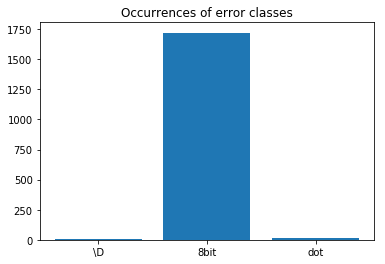

In [81]:
%matplotlib inline

ys = [troff_runner.no_backslash_d_failures,
      troff_runner.no_8bit_failures,
      troff_runner.no_dot_failures]

import matplotlib.pyplot as plt
plt.bar(["\\D", "8bit", "dot"], ys)
plt.title("Occurrences of error classes");


### Exercise 3: Run Real Troff

Using `BinaryProgramRunner`, apply the fuzzer you configured on the real `troff` program.  Check if you can produce any run whose output code is non-zero, indicating a failure or a crash.

**Solution.** This is just a matter of putting pieces together.

In [82]:
real_troff_runner = BinaryProgramRunner("troff")
for i in range(100):
    result, outcome = random_fuzzer.run(real_troff_runner)
    if outcome == Runner.FAIL:
        print(result)

Unfortunately, it is very unlikely that you'll find a bug in `troff` at this point.  Like most other open source code, it has been fuzzed this way before – and all errors found are already fixed.